have a look at pyro

In [403]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

import torch

from pyro.infer.mcmc import MCMC, NUTS
from pyro.infer.mcmc.nuts import HMC

plt.style.use('ggplot')

[Data](https://github.com/WillKoehrsen/ai-projects/tree/master/markov_chain_monte_carlo/data)

In [404]:
sleep_data = pd.read_csv('sleep_data.csv')
wake_data = pd.read_csv('wake_data.csv')

sleep_labels = ['21:00', '21:30', '22:00', '22:30', '23:00', '23:30', '00:00']
wake_labels = ['5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00']

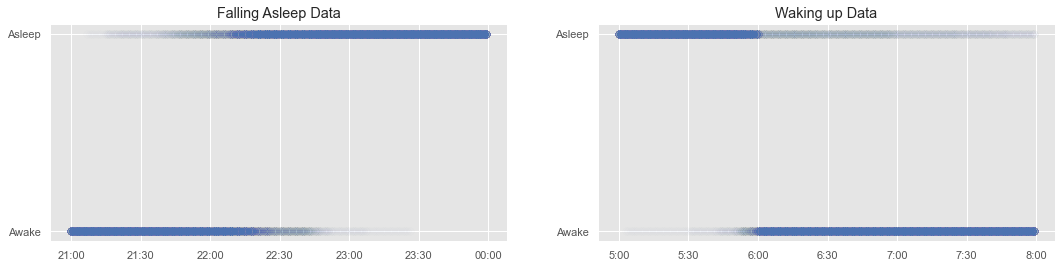

In [405]:
fig, axs = plt.subplots(1, 2, figsize=(18, 4))
axs[0].scatter(sleep_data['time_offset'], sleep_data['indicator'], 
            s= 60, alpha=0.01, facecolor = 'b', edgecolors='b')
axs[0].set_yticks([0, 1], ['Awake', 'Asleep']); 
axs[0].set_xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);
axs[0].set_title('Falling Asleep Data')

axs[1].scatter(wake_data['time_offset'], wake_data['indicator'], 
            s= 60, alpha=0.01, facecolor = 'b', edgecolors='b')
axs[1].set_yticks([0, 1], ['Awake', 'Asleep']); 
axs[1].set_xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);
axs[1].set_title('Waking up Data');

$$sleep_t \sim Bern(p_t)$$

$$p_t = Logistic(t, \alpha)$$

In [414]:
sleep_time = torch.Tensor(sleep_data['time_offset']).unsqueeze(-1)
sleep_ind = torch.Tensor(sleep_data['indicator'])

In [407]:
def sleep_model(data, obs):
    n_dim = data.shape[1]
    alpha = pyro.sample('alpha', dist.Normal(torch.zeros(n_dim), 10 * torch.ones(n_dim)))
    logits = torch.matmul(data, alpha.unsqueeze(-1)).squeeze(-1)
    return pyro.sample('obs', dist.Bernoulli(logits=logits), obs=obs)

In [408]:
pyro.clear_param_store()



nuts_kernel = NUTS(sleep_model, jit_compile=True)

mcmc_sleep = MCMC(
            nuts_kernel,
            num_samples=20000,
            warmup_steps=500
                 )


mcmc_sleep.run(sleep_time, sleep_ind)

Sample: 100%|█| 20500/20500 [00:23, 857.61it/s, step size=2.26e-01, acc. prob=0.


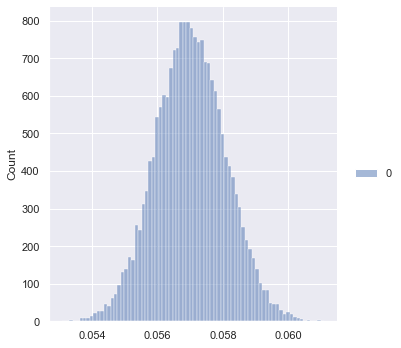

In [409]:
sns.set(rc={'figure.figsize':(10, 5)})
sns.displot(mcmc_sleep.get_samples()['coefs'].numpy(), kde=False);

In [410]:
time_est = np.linspace(sleep_time.min().numpy()- 15., sleep_time.max().numpy() + 15., 1000)
mean_alpha = mcmc_sleep.get_samples()['coefs'].mean().numpy()

logits = time_est * mean_alpha

In [411]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [412]:
sleep_probs = sigmoid(logits)

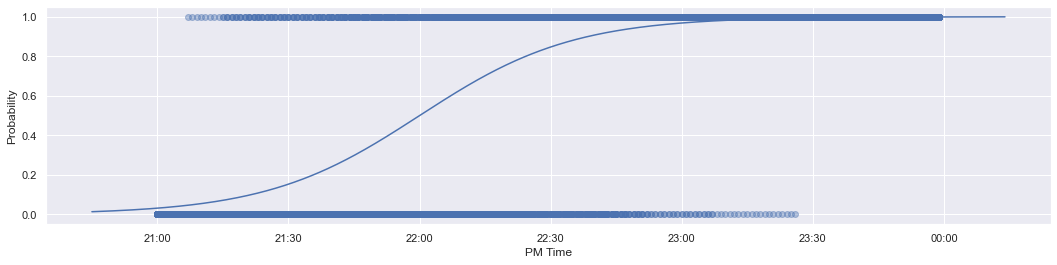

In [413]:
plt.figure(figsize=(18, 4))
plt.plot(time_est, sleep_probs)
plt.scatter(sleep_time, sleep_ind, alpha=0.4)
plt.ylabel('Probability')
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

In [415]:
wake_time = torch.Tensor(wake_data['time_offset']).unsqueeze(-1)
wake_ind = torch.Tensor(wake_data['indicator'])

In [416]:
pyro.clear_param_store()



nuts_kernel = NUTS(sleep_model, jit_compile=True)

mcmc_sleep = MCMC(
            nuts_kernel,
            num_samples=20000,
            warmup_steps=500
                 )


mcmc_sleep.run(wake_time, wake_ind)

Sample: 100%|█| 20500/20500 [00:27, 754.28it/s, step size=1.38e-01, acc. prob=0.


In [417]:
mean_alpha = mcmc_sleep.get_samples()['coefs'].mean().numpy()
logits = time_est * mean_alpha
wake_probs = sigmoid(logits)

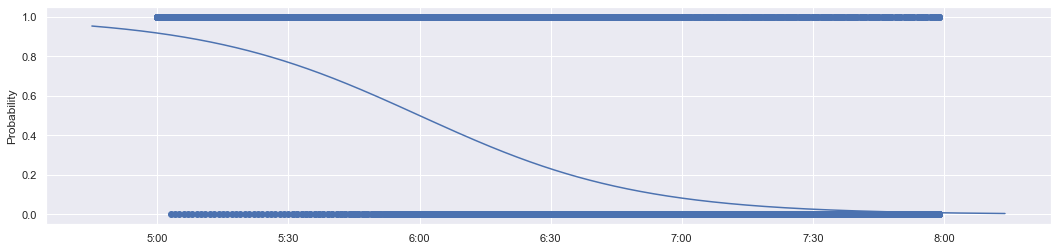

In [420]:
plt.figure(figsize=(18, 4))
plt.plot(time_est, wake_probs)
plt.scatter(sleep_time, wake_ind)
plt.ylabel('Probability')
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);